# Flare Flux Budget

In [1]:
import pathlib
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support, ImageNormalize, LogStretch, AsymmetricPercentileInterval
from astropy.convolution import convolve, Gaussian1DKernel
import ndcube
from ndcube.extra_coords import QuantityTableCoordinate
import fiasco
import aiapy.response

from fiasco.io import Parser
from synthesizAR.instruments import InstrumentDEM

from mocksipipeline.physics.spectral import get_spectral_tables
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response, ThinFilmFilter

%matplotlib inline

## Flux Budget for Flare DEMs

Set up flare DEM from CHIANTI

In [2]:
def dem_table_to_ndcube(dem_table):
    temperature = dem_table['temperature_bin_center']
    em = dem_table['dem']*np.gradient(temperature, edge_order=2)
    tab_coord = QuantityTableCoordinate(temperature,
                                        names='temperature',
                                        physical_types='phys.temperature')
    return ndcube.NDCube(em, wcs=tab_coord.wcs, meta=dem_table.meta)

In [3]:
tab_flare = Parser('flare.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse()
dem_flare = dem_table_to_ndcube(tab_flare)
tab_flare_ext = Parser('flare_ext.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse()
dem_flare_ext = dem_table_to_ndcube(tab_flare_ext)
tab_ar = Parser('active_region.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse()
dem_ar = dem_table_to_ndcube(tab_ar)

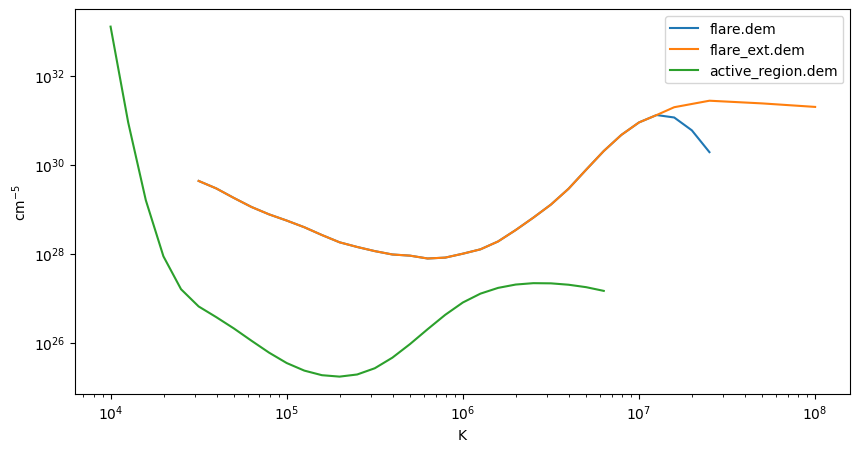

In [4]:
plt.figure(figsize=(10, 5))
with quantity_support():
    plt.plot(dem_flare.axis_world_coords(0)[0], dem_flare.data*dem_flare.unit, label='flare.dem')
    plt.plot(dem_flare_ext.axis_world_coords(0)[0], dem_flare_ext.data*dem_flare_ext.unit, label='flare_ext.dem')
    plt.plot(dem_ar.axis_world_coords(0)[0], dem_ar.data*dem_ar.unit, label='active_region.dem')
plt.xscale('log')
plt.yscale('log')
plt.legend()

Get spectra 

In [5]:
spec_tables = get_spectral_tables()

Set up instrument response

In [6]:
al_filter = ThinFilmFilter(elements='Al', thickness=150*u.nm, xrt_table='Chantler')

In [7]:
chan = SpectrogramChannel(1, al_filter)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


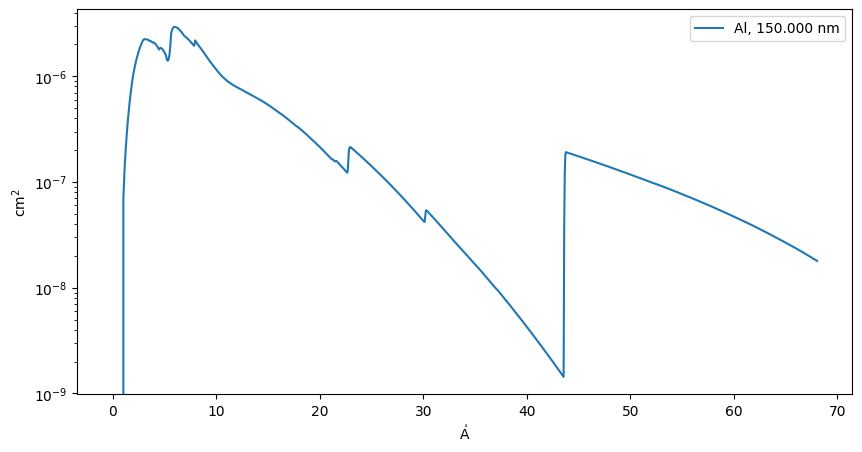

In [8]:
plt.figure(figsize=(10,5))
with quantity_support():
    plt.plot(chan.wavelength, chan.effective_area, label=chan.filter_label)
plt.yscale('log')
plt.legend()

Compute spectrum

In [9]:
intensity_flare = InstrumentDEM.calculate_intensity(dem_flare, spec_tables['sun_coronal_1992_feldman_ext_all'], {})
intensity_flare_ext = InstrumentDEM.calculate_intensity(dem_flare_ext, spec_tables['sun_coronal_1992_feldman_ext_all'], {})
intensity_ar = InstrumentDEM.calculate_intensity(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], {})
flux_flare = convolve_with_response(intensity_flare, chan, electrons=False, include_gain=False)
flux_flare_ext = convolve_with_response(intensity_flare_ext, chan, electrons=False, include_gain=False)
flux_ar = convolve_with_response(intensity_ar, chan, electrons=False, include_gain=False)

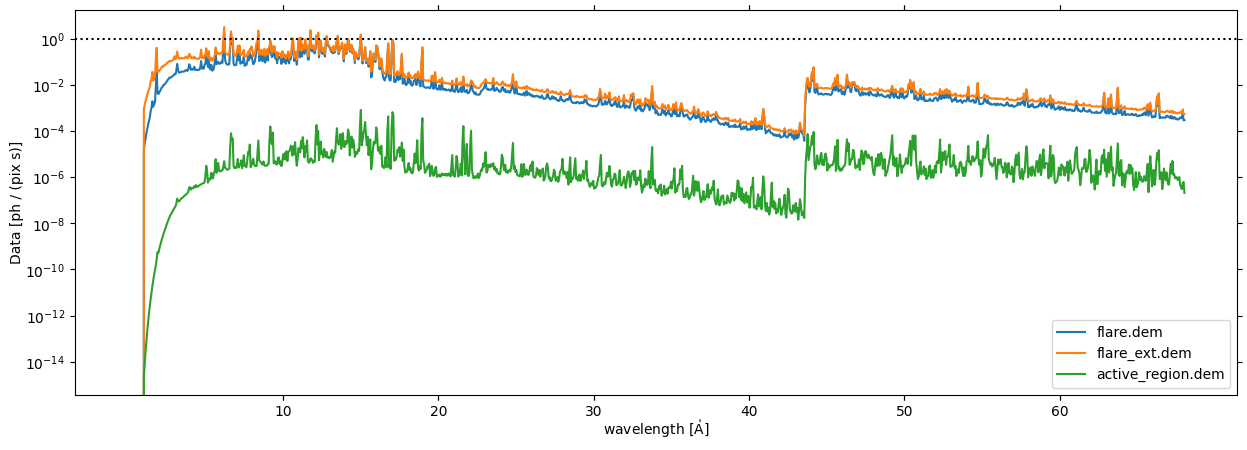

In [10]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare)
flux_flare.plot(axes=ax, label='flare.dem')
flux_flare_ext.plot(axes=ax, label='flare_ext.dem')
flux_ar.plot(axes=ax, label='active_region.dem')
ax.set_yscale('log')
ax.axhline(y=1, color='k', ls=':')
ax.legend()

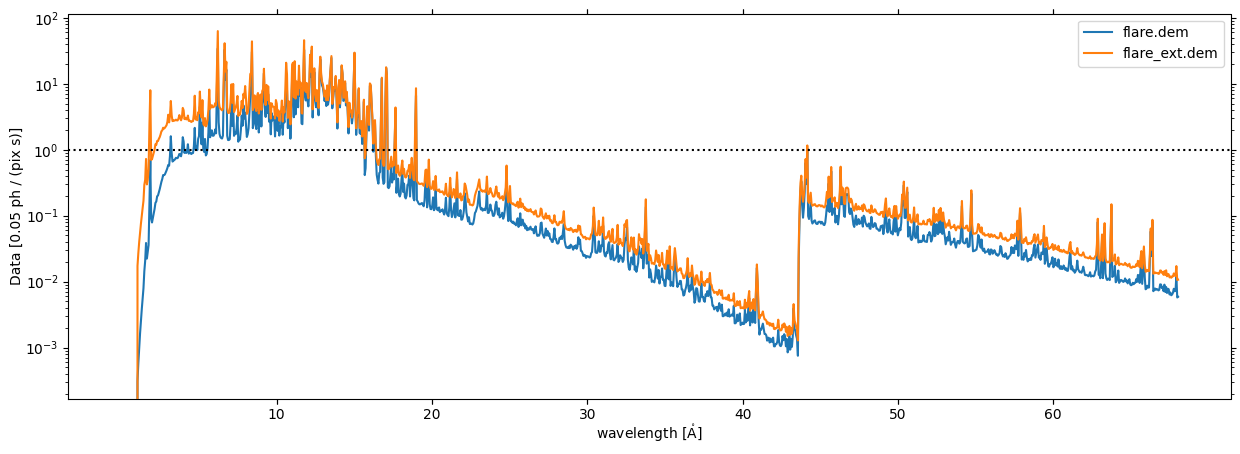

In [11]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare)
flux_flare.plot(axes=ax, label='flare.dem', data_unit=u.ph / u.pix / (20 * u.s))
flux_flare_ext.plot(axes=ax, label='flare_ext.dem', data_unit=u.ph / u.pix / (20 * u.s))
ax.set_yscale('log')
ax.axhline(y=1, color='k', ls=':')
ax.legend()

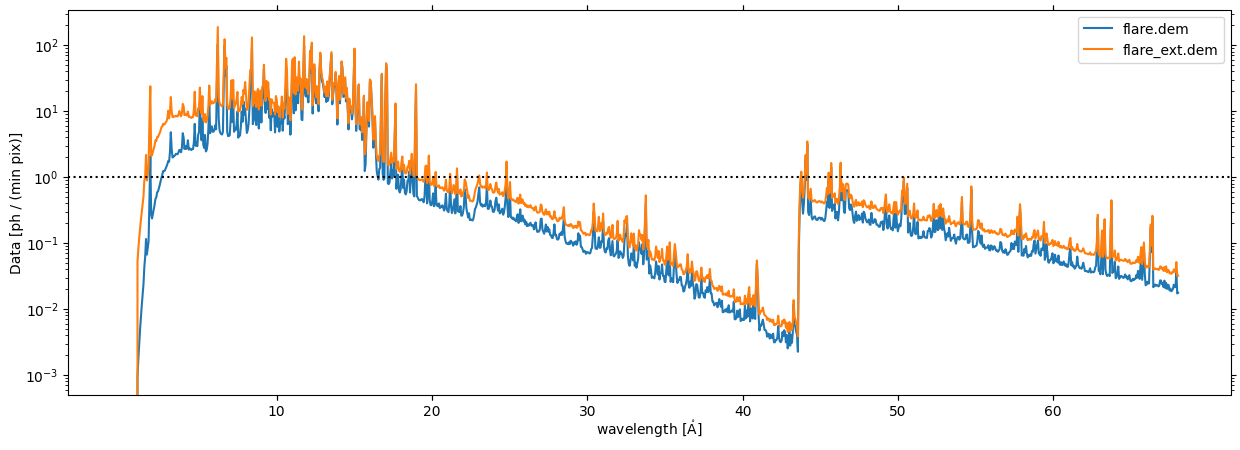

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare)
flux_flare.plot(axes=ax, label='flare.dem', data_unit=u.ph / u.pix /  u.minute)
flux_flare_ext.plot(axes=ax, label='flare_ext.dem', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.axhline(y=1, color='k', ls=':')
ax.legend()

## Effects on Spectral Resolution

In [13]:
def degrade_spectra(spec, resolution):
    std = resolution / (2*np.sqrt(2*np.log(2)))  # FWHM is 0.5 so convert to sigma using W = 2\sqrt{2\ln2}\sigma
    std_eff = (std / chan.spectral_resolution).to_value('pix')  # Scale sigma by bin width
    kernel = Gaussian1DKernel(std_eff)
    data_smooth = convolve(spec.data, kernel)
    return ndcube.NDCube(data_smooth, wcs=spec.wcs, meta=spec.meta, unit=spec.unit)

In [14]:
flux_05 = degrade_spectra(flux_flare_ext, 0.5*u.angstrom)
flux_10 = degrade_spectra(flux_flare_ext, 1*u.angstrom)

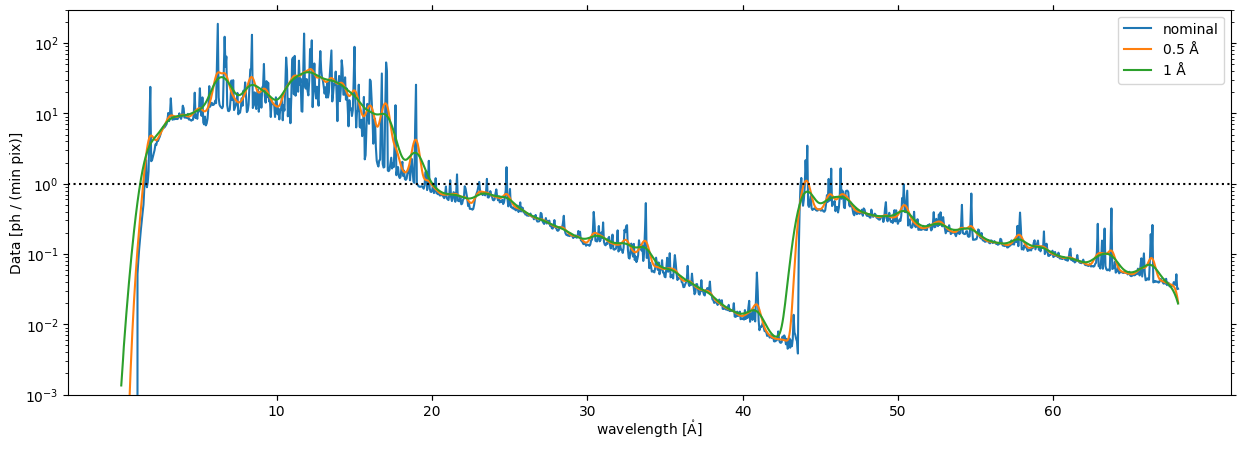

In [15]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
ax.legend()

Looking at particular lines

In [16]:
line_ids = [
    ('Fe XVIII',14.21*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 15.01*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 16.78*u.AA),
    ('Fe XVII', 17.05*u.AA),
    ('O VII', 21.60*u.angstrom),  # also targeted by MaGIXS
    ('O VII', 21.81*u.angstrom),
    ('O VII', 22.10*u.AA),
    ('O VIII', 18.97*u.angstrom),  # also targeted by MaGIXS
    ('Fe XXV', 1.86*u.AA),
    ('Ca XIX', 3.21*u.AA),
    ('Si XIII', 6.74*u.AA),
    ('Mg XI', 9.32*u.AA),
    ('Fe XVII', 11.25*u.AA),
    ('Fe XX', 12.83*u.AA),
    ('Ne IX', 13.45*u.AA),
    ('Fe XIX', 13.53*u.AA),
    ('C VI', 33.73*u.AA),
    ('C V', 40.27*u.AA),
    ('Si XII', 44.16*u.AA),
    ('Si XI', 49.18*u.AA),
]

In [17]:
def add_line_ids_to_axis(ax, line_ids, rotation=90):
    for ion,line in line_ids:
        ax.axvline(x=ax.wcs.world_to_pixel(line), ls=':', color='k',)
    ax2 = ax.secondary_xaxis('top') 
    ax2.set_xticks(ax.wcs.world_to_pixel(u.Quantity([l for _,l in line_ids])),
                   labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
                   rotation=rotation,
                   horizontalalignment='center',
                   #verticalalignment='center'
                  )

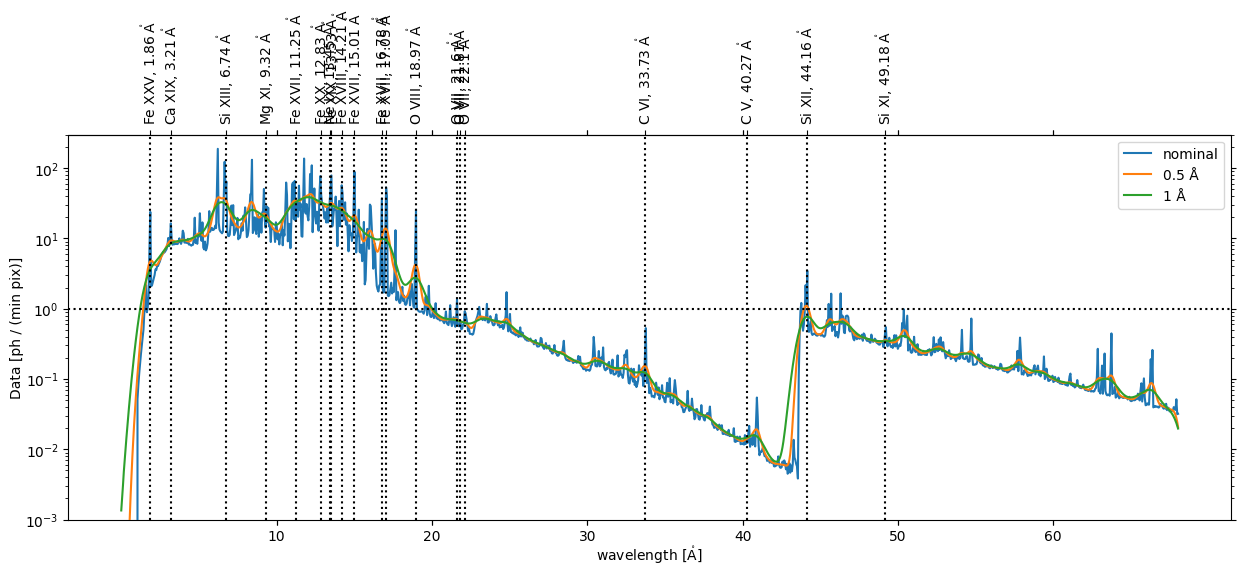

In [18]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
ax.legend()
add_line_ids_to_axis(ax, line_ids)
#ax.set_xlim(ax.wcs.world_to_pixel([14,23]*u.angstrom))

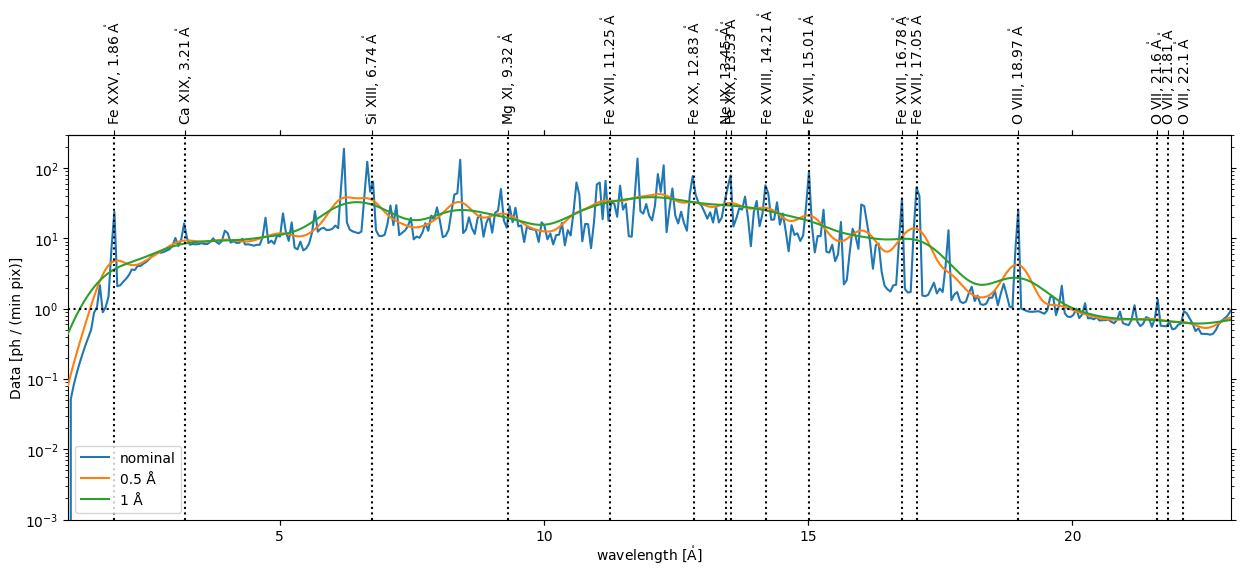

In [19]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
add_line_ids_to_axis(ax, line_ids)
ax.set_xlim(ax.wcs.world_to_pixel([1,23]*u.angstrom))
ax.legend(loc=3)

(254.54545454545456, 418.18181818181824)

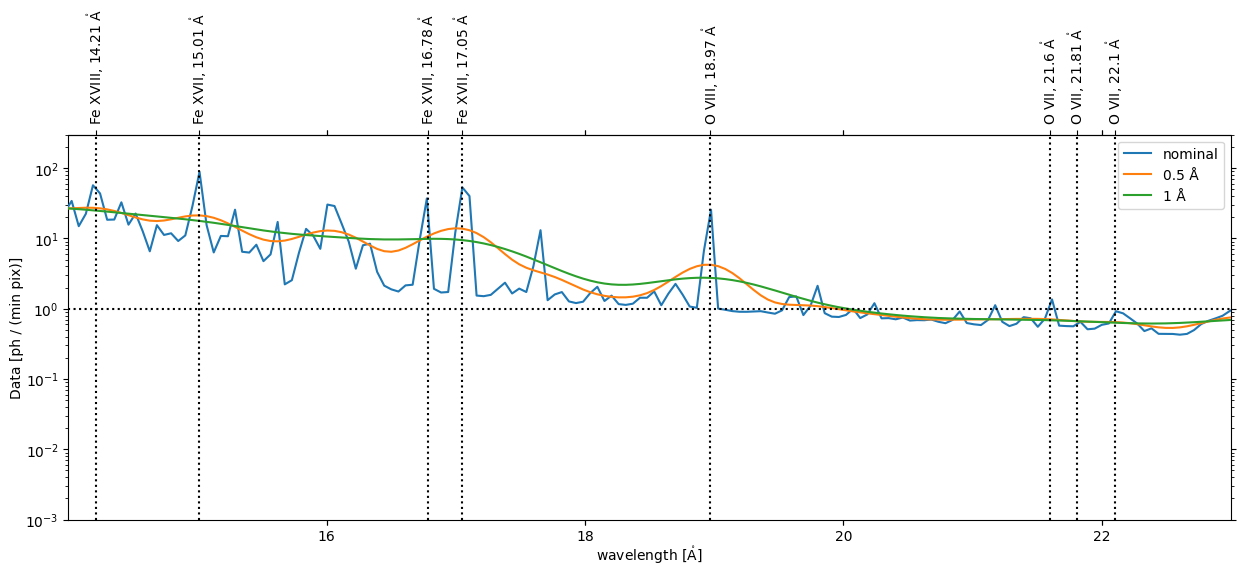

In [20]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
ax.legend()
add_line_ids_to_axis(ax, line_ids)
ax.set_xlim(ax.wcs.world_to_pixel([14,23]*u.angstrom))

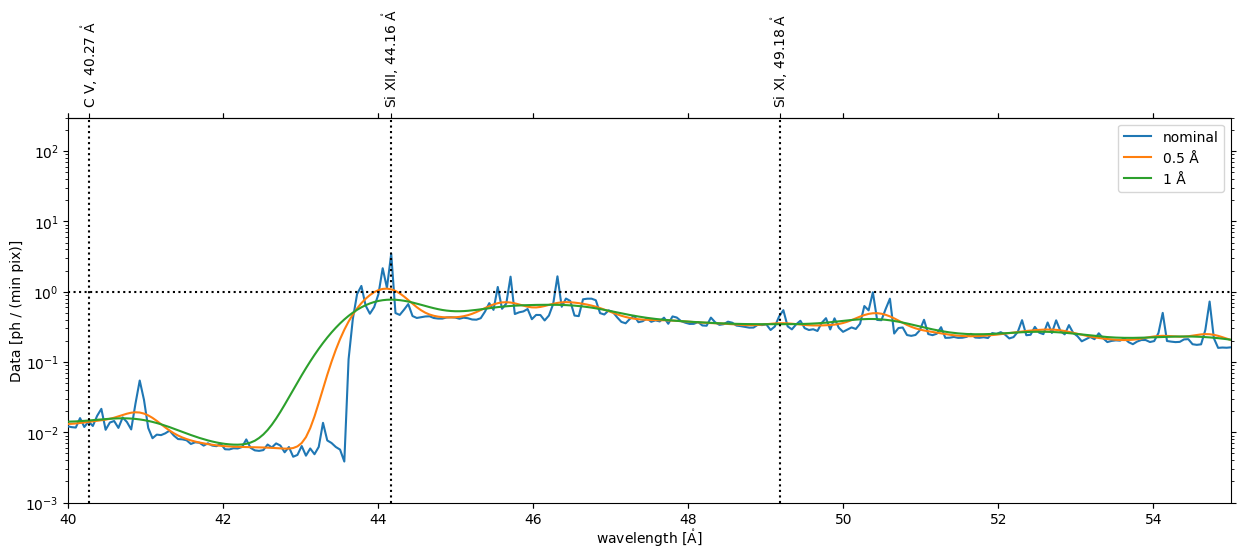

In [21]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
add_line_ids_to_axis(ax, line_ids)
ax.set_xlim(ax.wcs.world_to_pixel([40,55]*u.angstrom))
ax.legend(loc=1)

## Comparisons in Different Bandpasses

Trying to reconcile what is happening in the CHIANTI IDL GUI and what I'm doing here...I want to make sure what I'm doing here is not wrong and I'm not missing an order of magnitude somewhere

In my investigation with the IDL `ch_ss` GUI, the plot below is fairly consistent with what is calculated there, for the `flare.dem` dataset.

(100000000000000.0, 1e+17)

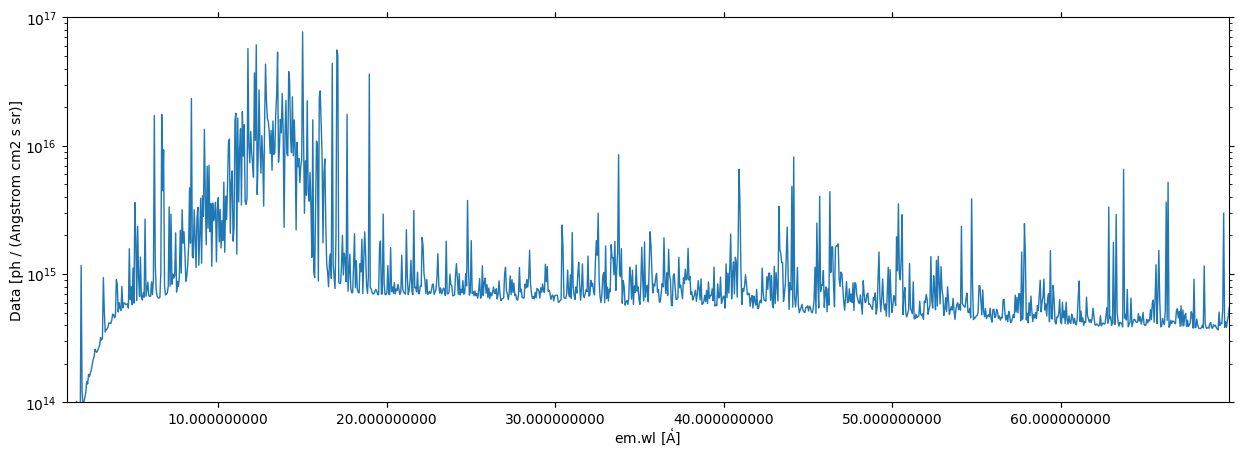

In [22]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=intensity_flare)
intensity_flare.plot(axes_units='Angstrom', axes=ax, lw=1)
ax.set_xlim(ax.wcs.world_to_pixel([1,70]*u.angstrom))
ax.set_yscale('log')
ax.set_ylim(1e14,1e17)

This seems really high, but then remembering we are multiplying by the following instrument response (in appropriate units)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


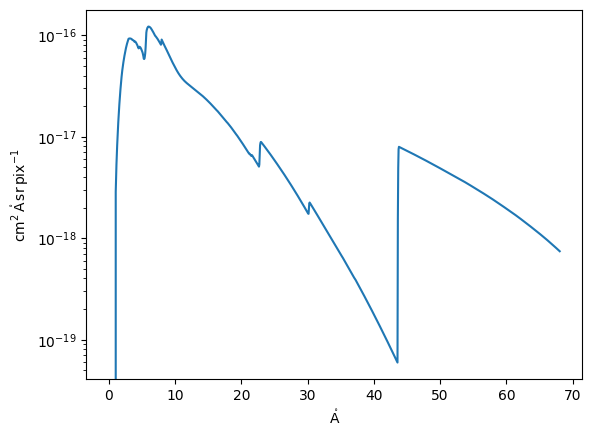

In [23]:
with quantity_support():
    plt.plot(chan.wavelength, chan.plate_scale * chan.effective_area * chan.spectral_resolution * 1 * u.pix)
plt.yscale('log')

Just eyballing things, you can see that we're only just barely getting above 1 ph pix$^{-1}$ s$^{-1}$ near 10 Å

So then a natural question is: if we were to observe this same "patch of Sun" with AIA, what would we see?

In [24]:
class ChannelAIA(aiapy.response.Channel):
    
    @property
    @u.quantity_input
    def spectral_resolution(self):
        return np.diff(self.wavelength)[0] / u.pix

Let's first compare all of the response functions in appropriate units

(1e-10, 10.0)

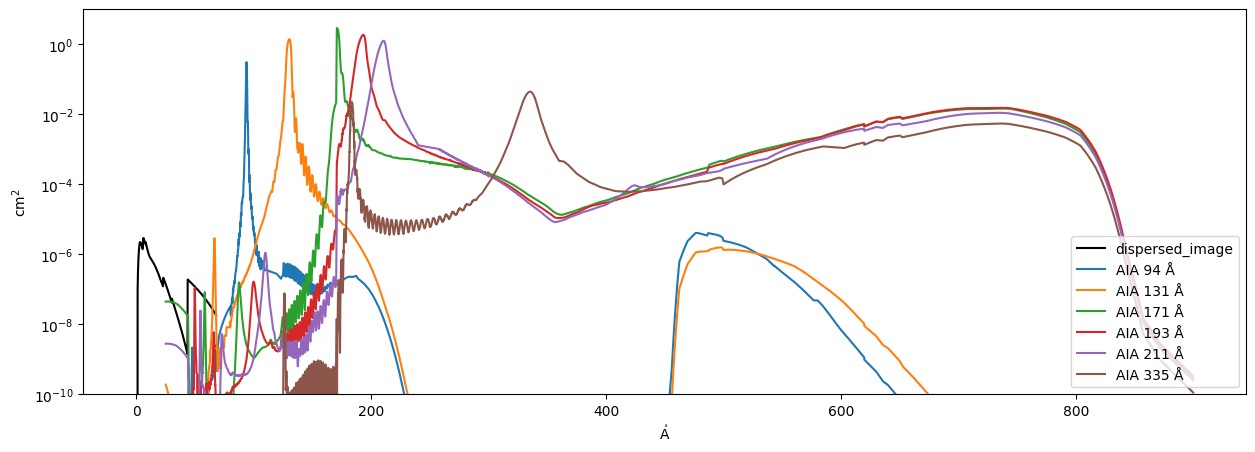

In [25]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
with quantity_support():
    ax.plot(chan.wavelength, chan.effective_area, label=chan.name, color='k')
    for aia_wave in [94, 131, 171, 193, 211, 335]*u.angstrom:
        chan_aia = ChannelAIA(aia_wave)
        ax.plot(chan_aia.wavelength, chan_aia.effective_area, label=f'AIA {chan_aia.name} Å')
ax.set_yscale('log')
ax.legend(loc=4)
ax.set_ylim(1e-10, 1e1)

(1e-18, 1e-10)

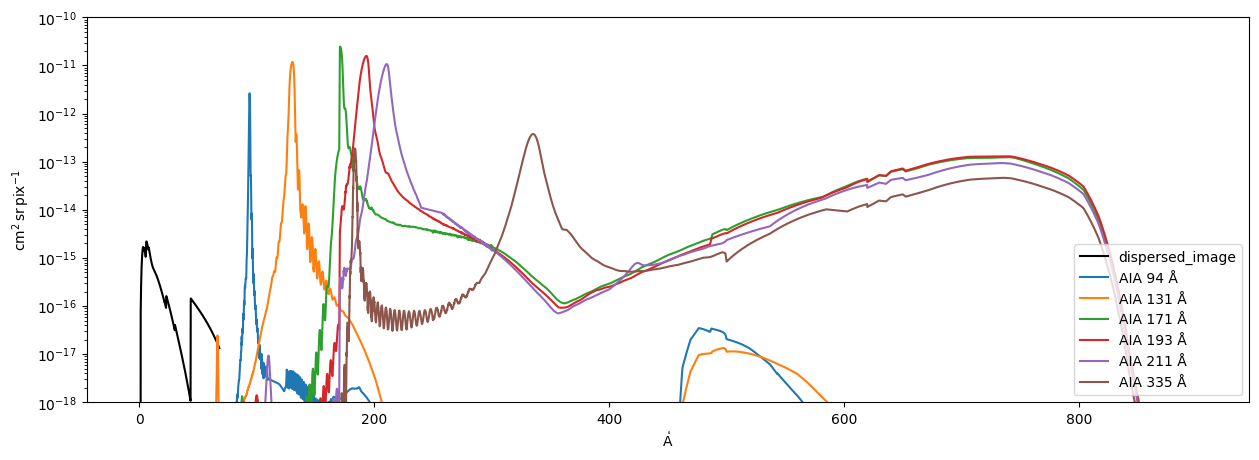

In [26]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
with quantity_support():
    ax.plot(chan.wavelength, chan.plate_scale * chan.effective_area,
             label=chan.name, color='k')
    for aia_wave in [94, 131, 171, 193, 211, 335]*u.angstrom:
        chan_aia = ChannelAIA(aia_wave)
        ax.plot(chan_aia.wavelength, chan_aia.effective_area*chan_aia.plate_scale,
                label=f'AIA {chan_aia.name} Å')
ax.set_yscale('log')
ax.legend(loc=4)
ax.set_ylim(1e-18, 1e-10)

Let's look first at the active region case. Looking below, we can see that we are getting pretty typical (based on AIA AR observations) numbers here. The numbers in the legend show what we'd expect to actually observe in an AIA pixel.

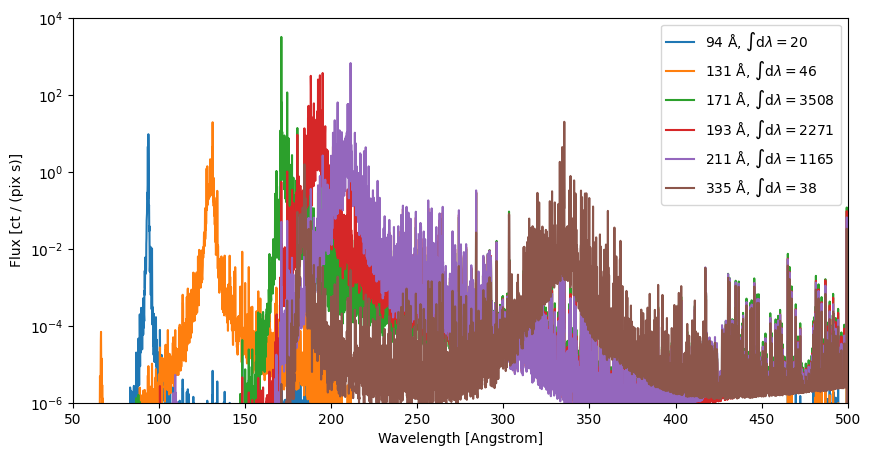

In [27]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
for aia_wave in [94, 131, 171, 193, 211, 335]*u.angstrom:
    chan_aia = ChannelAIA(aia_wave)
    flux_ar_aia = convolve_with_response(intensity_ar, chan_aia, electrons=False, )
    flux_ar_aia = ndcube.NDCube(flux_ar_aia.data*flux_ar_aia.unit*chan_aia.gain,
                                wcs=flux_ar_aia.wcs)
    summed_counts = flux_ar_aia.data.sum()
    ax.plot(chan_aia.wavelength, flux_ar_aia.data, label=f'{aia_wave.value:.0f} Å, $\int\mathrm{{d}}\lambda={summed_counts:.0f}$')
ax.set_yscale('log')
ax.set_ylim(1e-6, 1e4)
ax.set_xlim(50, 500)
ax.set_ylabel(f'Flux [{flux_ar_aia.unit}]')
ax.set_xlabel(f'Wavelength [{chan_aia.wavelength.unit}]')
ax.legend(ncol=1)

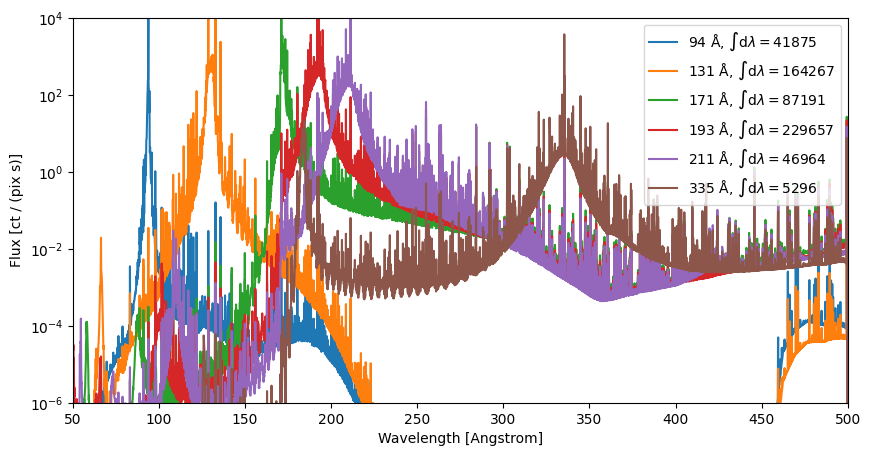

In [28]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
for aia_wave in [94, 131, 171, 193, 211, 335]*u.angstrom:
    chan_aia = ChannelAIA(aia_wave)
    flux_flare_aia = convolve_with_response(intensity_flare, chan_aia, electrons=False, )
    flux_flare_aia = ndcube.NDCube(flux_flare_aia.data*flux_flare_aia.unit*chan_aia.gain,
                                wcs=flux_flare_aia.wcs)
    summed_counts = flux_flare_aia.data.sum()
    ax.plot(chan_aia.wavelength, flux_flare_aia.data, label=f'{aia_wave.value:.0f} Å, $\int\mathrm{{d}}\lambda={summed_counts:.0f}$')
ax.set_yscale('log')
ax.set_ylim(1e-6, 1e4)
ax.set_xlim(50, 500)
ax.set_ylabel(f'Flux [{flux_flare_aia.unit}]')
ax.set_xlabel(f'Wavelength [{chan_aia.wavelength.unit}]')
ax.legend(ncol=1)

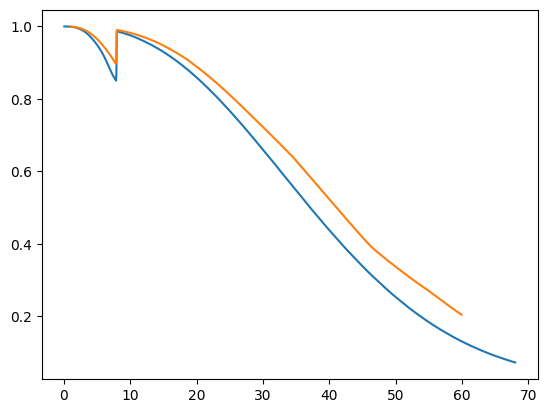

In [35]:
plt.plot(chan.wavelength, chan.filter_transmission)
plt.plot(chan._wavelength_data, chan._data['filter'])
#plt.yscale('log')